In [3]:
import pandas as pd

In [4]:
final_results=pd.read_csv('/content/drive/MyDrive/neuro_data/Neuroface/feature_extraction.csv')
final_results.head()

,Unnamed: 0,LLpath,Arange,Amean,Adiff,vWmax,vWmin,vLLmax,vLLmin,range_of_e,mean_of_e,r_symm,disease_type,Task_Name,Subject_ID
0,0,152.395692,28.065254,-32.823020,-7.917311,18.370284,6.428785,1.332419,-0.006831,0.004263,0.989645,0.984915,HC,SPREAD,N004
1,1,160.233415,57.006664,-9.637524,-9.648731,22.838705,4.013419,2.969074,1.874726,0.002254,0.985067,0.929064,HC,SPREAD,N004
2,2,151.528577,47.148374,-23.781802,-17.024300,24.681926,2.379753,3.269666,0.688155,0.000878,0.988587,0.958457,HC,SPREAD,N004
3,3,155.651733,39.432462,-24.977782,-3.495013,17.894835,3.566531,1.687981,1.661038,0.002226,0.987817,0.966624,HC,SPREAD,N004
4,4,158.751312,62.257054,-7.597097,-15.665155,21.201795,9.329976,2.847623,2.013252,0.001954,0.984738,0.879259,HC,SPREAD,N004


In [5]:
PS_values=final_results[final_results['disease_type']=='PS']

In [6]:
final_result1=final_results.drop(PS_values.index)

In [7]:
final_result1.shape

(610, 15)

In [8]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    # For binary classification: extract sensitivity and specificity if possible
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    else:
        sensitivity = None
        specificity = None
    return acc, cm, sensitivity, specificity

In [33]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
import numpy as np

# Encode target labels
final_result1['disease_type'] = final_result1['disease_type'].astype('category').cat.codes

# Get unique task names
tasks = final_result1['Task_Name'].unique()

# Initialize results dictionary
results_logistic_grid = {}

# Define hyperparameter ranges
param_grid = {
    'C': [2**i for i in range(-5, 16, 2)],  # C = [2^-5, 2^-3, ..., 2^15]
}

for task in tasks:
    print(f"\n--- Task: {task} ---")

    # Filter data for the current task
    task_data = final_result1[final_result1['Task_Name'] == task]
    x = task_data.drop(columns=['disease_type', 'Task_Name', 'Subject_ID'])
    y = task_data['disease_type']

    # Group by Subject_ID (each subject is a group)
    groups = task_data['Subject_ID']

    # Standardize the features
    scaler = StandardScaler()
    x_standardized = scaler.fit_transform(x)

    # Leave-One-Group-Out Cross-Validation
    logo = LeaveOneGroupOut()

    # For storing group-level predictions for three cases
    y_true_groups = []  # Ground truth (per group)
    y_pred_first = []   # Prediction from the first repetition in the group
    y_pred_voting = []  # Prediction by majority vote over group repetitions
    y_pred_best = []    # Prediction from the repetition with highest confidence
    training_accuracies = []
    y_true_groups_rep=[]

    for train_idx, test_idx in logo.split(x_standardized, y, groups):
        # Split data into training and test sets for this fold
        x_train, x_test = x_standardized[train_idx], x_standardized[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # GridSearchCV for hyperparameter tuning on training data
        grid_search = GridSearchCV(
            estimator=LogisticRegression(max_iter=1000000000),
            param_grid=param_grid,
            scoring='accuracy',
            cv=None,
            verbose=0
        )
        grid_search.fit(x_train, y_train)

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Predict probabilities and labels on the test (group) set
        y_probs = best_model.predict_proba(x_test)  # shape: (n_repetitions, n_classes)
        y_preds = best_model.predict(x_test)

        # The group’s ground truth label (assumed identical across repetitions)
        group_true = y_test.iloc[0]
        y_true_groups.append(group_true)
        ground_true_rep=[group_true]*len(y_preds)
        y_true_groups_rep.extend(ground_true_rep)

        # --- Case 1: First Repetition ---
        # Use the prediction from the first sample in the group.
        for i in range(len(y_preds)):
          y_pred_first.append(y_preds[i])

        # --- Case 2: Voting ---
        # Use majority vote across all repetitions in the group.
        counts = np.bincount(y_preds)
        y_vote = np.argmax(counts)
        y_pred_voting.append(y_vote)

        # --- Case 3: Best Repetition ---
        # For each sample, determine the maximum predicted probability (i.e. confidence).
        # Select the repetition with the highest confidence.
        confidences = np.max(y_probs, axis=1)
        best_index = np.argmax(confidences)
        y_pred_best.append(y_preds[best_index])

        # Also compute and store training accuracy for this fold
        y_train_pred = best_model.predict(x_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        training_accuracies.append(train_accuracy)

    # Compute metrics for each case after collecting all fold predictions
    acc_first, cm_first, sen_first, spec_first = compute_metrics(y_true_groups_rep, y_pred_first)
    acc_voting, cm_voting, sen_voting, spec_voting = compute_metrics(y_true_groups, y_pred_voting)
    acc_best, cm_best, sen_best, spec_best = compute_metrics(y_true_groups, y_pred_best)
    avg_training_accuracy = np.mean(training_accuracies)

    # Now print the computed metrics
    print(f"Task: {task}")
    print("First Repetition Accuracy: {:.4f}".format(acc_first))
    print("Voting-Based Accuracy: {:.4f}".format(acc_voting))
    print("Best Repetition Accuracy: {:.4f}".format(acc_best))
    print("Training Accuracy: {:.4f}".format(avg_training_accuracy))
    print("Metrics for Task:", task)
    print("Confusion Matrix (First Repetition):")
    print(cm_first)
    print("Sensitivity: {:.4f}".format(sen_first))
    print("Specificity: {:.4f}".format(spec_first))
    print("Confusion Matrix (Voting Repetition):")
    print(cm_voting)
    print("Sensitivity: {:.4f}".format(sen_voting))
    print("Specificity: {:.4f}".format(spec_voting))
    print("Confusion Matrix (best Repetition):")
    print(cm_best)
    print("Sensitivity: {:.4f}".format(sen_best))
    print("Specificity: {:.4f}".format(spec_best))

    # Store results
    results_logistic_grid[task] = {
        'First Repetition': {
            'Accuracy': acc_first,
            'Confusion Matrix': cm_first,
            'Sensitivity': sen_first,
            'Specificity': spec_first
        },
        'Voting': {
            'Accuracy': acc_voting,
            'Confusion Matrix': cm_voting,
            'Sensitivity': sen_voting,
            'Specificity': spec_voting
        },
        'Best Repetition': {
            'Accuracy': acc_best,
            'Confusion Matrix': cm_best,
            'Sensitivity': sen_best,
            'Specificity': spec_best
        },
        'Training Accuracy': avg_training_accuracy
    }

    print("----------------------------------------------------")



--- Task: SPREAD ---
Task: SPREAD
First Repetition Accuracy: 0.8132
Voting-Based Accuracy: 0.8182
Best Repetition Accuracy: 0.8636
Training Accuracy: 0.9906
Metrics for Task: SPREAD
Confusion Matrix (First Repetition):
[[36  8]
 [ 9 38]]
Sensitivity: 0.8085
Specificity: 0.8182
Confusion Matrix (Voting Repetition):
[[9 2]
 [2 9]]
Sensitivity: 0.8182
Specificity: 0.8182
Confusion Matrix (best Repetition):
[[10  1]
 [ 2  9]]
Sensitivity: 0.8182
Specificity: 0.9091
----------------------------------------------------

--- Task: PA ---
Task: PA
First Repetition Accuracy: 0.8315
Voting-Based Accuracy: 0.8571
Best Repetition Accuracy: 0.8571
Training Accuracy: 0.9607
Metrics for Task: PA
Confusion Matrix (First Repetition):
[[33  9]
 [ 6 41]]
Sensitivity: 0.8723
Specificity: 0.7857
Confusion Matrix (Voting Repetition):
[[ 8  2]
 [ 1 10]]
Sensitivity: 0.9091
Specificity: 0.8000
Confusion Matrix (best Repetition):
[[ 8  2]
 [ 1 10]]
Sensitivity: 0.9091
Specificity: 0.8000
---------------------

In [32]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
import numpy as np

# Encode target labels
final_result1['disease_type'] = final_result1['disease_type'].astype('category').cat.codes

# Get unique task names
tasks = final_result1['Task_Name'].unique()

# Initialize results dictionary
results_svm_linear_grid = {}

# Define hyperparameter ranges; note that we include probability=True
param_grid = {
    'C': [2**i for i in range(-5, 16, 2)],  # C = [2^-5, 2^-3, ..., 2^15]
    'kernel': ['linear'],
    'probability': [True]  # enable probability estimation for confidence scores
}

for task in tasks:
    print(f"\n--- Task: {task} ---")

    # Filter data for the current task
    task_data = final_result1[final_result1['Task_Name'] == task]
    x = task_data.drop(columns=['disease_type', 'Task_Name', 'Subject_ID'])
    y = task_data['disease_type']

    # Group by Subject_ID (each subject is a group)
    groups = task_data['Subject_ID']

    # Standardize the features
    scaler = StandardScaler()
    x_standardized = scaler.fit_transform(x)

    # Use Leave-One-Group-Out cross-validation
    logo = LeaveOneGroupOut()

    # For storing group-level predictions for three cases
    y_true_groups = []  # Ground truth (per group)
    y_pred_first = []   # Prediction from the first repetition in the group
    y_pred_voting = []  # Prediction by majority vote over group repetitions
    y_pred_best = []    # Prediction from the repetition with highest confidence
    y_true_groups_rep=[]
    training_accuracies = []

    for train_idx, test_idx in logo.split(x_standardized, y, groups):
        # Get training and test sets for this fold (one subject left out)
        x_train, x_test = x_standardized[train_idx], x_standardized[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Hyperparameter tuning using GridSearchCV on training data
        grid_search = GridSearchCV(
            estimator=SVC(),
            param_grid=param_grid,
            scoring='accuracy',
            cv=None,
            verbose=0
        )
        grid_search.fit(x_train, y_train)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Predict probabilities and labels on the test (group) set
        y_probs = best_model.predict_proba(x_test)  # shape: (n_repetitions, n_classes)
        y_preds = best_model.predict(x_test)

        # The group’s ground truth label (assumed identical across repetitions)
        group_true = y_test.iloc[0]
        y_true_groups.append(group_true)
        ground_true_rep=[group_true]*len(y_preds)
        y_true_groups_rep.extend(ground_true_rep)

        # --- Case 1: First Repetition ---
        # Use the prediction from the first sample in the group.
        for i in range(len(y_preds)):
          y_pred_first.append(y_preds[i])

        # --- Case 2: Voting ---
        # Use majority vote across all repetitions in the group.
        counts = np.bincount(y_preds)
        y_vote = np.argmax(counts)
        y_pred_voting.append(y_vote)

        # --- Case 3: Best Repetition ---
        # For each sample, determine the maximum predicted probability (i.e. confidence).
        # Select the repetition with the highest confidence.
        confidences = np.max(y_probs, axis=1)
        best_index = np.argmax(confidences)
        y_pred_best.append(y_preds[best_index])

        # Also compute and store training accuracy for this fold
        y_train_pred = best_model.predict(x_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        training_accuracies.append(train_accuracy)


    # Compute metrics for each case
    acc_first, cm_first, sen_first, spec_first = compute_metrics(y_true_groups_rep, y_pred_first)
    acc_voting, cm_voting, sen_voting, spec_voting = compute_metrics(y_true_groups, y_pred_voting)
    acc_best, cm_best, sen_best, spec_best = compute_metrics(y_true_groups, y_pred_best)
    avg_training_accuracy = np.mean(training_accuracies)

    print(f"Task: {task}")
    print("First Repetition Accuracy: {:.4f}".format(acc_first))
    print("Voting-Based Accuracy: {:.4f}".format(acc_voting))
    print("Best Repetition Accuracy: {:.4f}".format(acc_best))
    print("Training Accuracy: {:.4f}".format(avg_training_accuracy))
    print("Metrics for Task:", task)
    print("Confusion Matrix (First Repetition):")
    print(cm_first)
    print("Sensitivity: {:.4f}".format(sen_first))
    print("Specificity: {:.4f}".format(spec_first))
    print("Confusion Matrix (Voting Repetition):")
    print(cm_voting)
    print("Sensitivity: {:.4f}".format(sen_voting))
    print("Specificity: {:.4f}".format(spec_voting))
    print("Confusion Matrix (best Repetition):")
    print(cm_best)
    print("Sensitivity: {:.4f}".format(sen_best))
    print("Specificity: {:.4f}".format(spec_best))

    # Store the results for the current task
    results_svm_linear_grid[task] = {
        'First Repetition': {
            'Accuracy': acc_first,
            'Confusion Matrix': cm_first,
            'Sensitivity': sen_first,
            'Specificity': spec_first
        },
        'Voting': {
            'Accuracy': acc_voting,
            'Confusion Matrix': cm_voting,
            'Sensitivity': sen_voting,
            'Specificity': spec_voting
        },
        'Best Repetition': {
            'Accuracy': acc_best,
            'Confusion Matrix': cm_best,
            'Sensitivity': sen_best,
            'Specificity': spec_best
        },
        'Training Accuracy': avg_training_accuracy
    }

    print("----------------------------------------------------")

# The results for all tasks are now stored in results_svm_linear_grid



--- Task: SPREAD ---
Task: SPREAD
First Repetition Accuracy: 0.8462
Voting-Based Accuracy: 0.8636
Best Repetition Accuracy: 0.9091
Training Accuracy: 0.9828
Metrics for Task: SPREAD
Confusion Matrix (First Repetition):
[[38  6]
 [ 8 39]]
Sensitivity: 0.8298
Specificity: 0.8636
Confusion Matrix (Voting Repetition):
[[10  1]
 [ 2  9]]
Sensitivity: 0.8182
Specificity: 0.9091
Confusion Matrix (best Repetition):
[[11  0]
 [ 2  9]]
Sensitivity: 0.8182
Specificity: 1.0000
----------------------------------------------------

--- Task: PA ---
Task: PA
First Repetition Accuracy: 0.8652
Voting-Based Accuracy: 0.9048
Best Repetition Accuracy: 0.8571
Training Accuracy: 0.9803
Metrics for Task: PA
Confusion Matrix (First Repetition):
[[33  9]
 [ 3 44]]
Sensitivity: 0.9362
Specificity: 0.7857
Confusion Matrix (Voting Repetition):
[[ 8  2]
 [ 0 11]]
Sensitivity: 1.0000
Specificity: 0.8000
Confusion Matrix (best Repetition):
[[ 8  2]
 [ 1 10]]
Sensitivity: 0.9091
Specificity: 0.8000
-----------------

In [34]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
import numpy as np

# Encode target labels
final_result1['disease_type'] = final_result1['disease_type'].astype('category').cat.codes

# Get unique task names
tasks = final_result1['Task_Name'].unique()

# Initialize results dictionary
results_svm_rbf_grid = {}

# Define hyperparameter ranges; note that we include probability=True
param_grid = {
    'C': [2**i for i in range(-5, 16, 2)],  # C = [2^-5, 2^-3, ..., 2^15]
    'gamma': [2**i for i in range(-15, 4, 2)],  # gamma = [2^-15, 2^-13, ..., 2^3]
    'kernel': ['rbf'],
    'probability': [True]  # enable probability estimation for confidence scores
}

for task in tasks:
    print(f"\n--- Task: {task} ---")

    # Filter data for the current task
    task_data = final_result1[final_result1['Task_Name'] == task]
    x = task_data.drop(columns=['disease_type', 'Task_Name', 'Subject_ID'])
    y = task_data['disease_type']

    # Group by Subject_ID (each subject is a group)
    groups = task_data['Subject_ID']

    # Standardize the features
    scaler = StandardScaler()
    x_standardized = scaler.fit_transform(x)

    # Use Leave-One-Group-Out cross-validation
    logo = LeaveOneGroupOut()

    # For storing group-level predictions for three cases
    y_true_groups = []  # Ground truth (per group)
    y_pred_first = []   # Prediction from the first repetition in the group
    y_pred_voting = []  # Prediction by majority vote over group repetitions
    y_pred_best = []    # Prediction from the repetition with highest confidence

    training_accuracies = []
    y_true_groups_rep=[]

    for train_idx, test_idx in logo.split(x_standardized, y, groups):
        # Get training and test sets for this fold (one subject left out)
        x_train, x_test = x_standardized[train_idx], x_standardized[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Hyperparameter tuning using GridSearchCV on training data
        grid_search = GridSearchCV(
            estimator=SVC(),
            param_grid=param_grid,
            scoring='accuracy',
            cv=None,
            verbose=0
        )
        grid_search.fit(x_train, y_train)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Predict probabilities and labels on the test (group) set
        y_probs = best_model.predict_proba(x_test)  # shape: (n_repetitions, n_classes)
        y_preds = best_model.predict(x_test)

        group_true = y_test.iloc[0]
        y_true_groups.append(group_true)
        ground_true_rep=[group_true]*len(y_preds)
        y_true_groups_rep.extend(ground_true_rep)

        # --- Case 1: First Repetition ---
        # Use the prediction from the first sample in the group.
        for i in range(len(y_preds)):
          y_pred_first.append(y_preds[i])


        # --- Case 2: Voting ---
        # Use majority vote across all repetitions in the group.
        counts = np.bincount(y_preds)
        y_vote = np.argmax(counts)
        y_pred_voting.append(y_vote)

        # --- Case 3: Best Repetition ---
        # For each sample, determine the maximum predicted probability (i.e. confidence).
        # Select the repetition with the highest confidence.
        confidences = np.max(y_probs, axis=1)
        best_index = np.argmax(confidences)
        y_pred_best.append(y_preds[best_index])

        # Also compute and store training accuracy for this fold
        y_train_pred = best_model.predict(x_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        training_accuracies.append(train_accuracy)



    # Compute metrics for each case
    acc_first, cm_first, sen_first, spec_first = compute_metrics(y_true_groups_rep, y_pred_first)
    acc_voting, cm_voting, sen_voting, spec_voting = compute_metrics(y_true_groups, y_pred_voting)
    acc_best, cm_best, sen_best, spec_best = compute_metrics(y_true_groups, y_pred_best)
    avg_training_accuracy = np.mean(training_accuracies)

    print(f"Task: {task}")
    print("First Repetition Accuracy: {:.4f}".format(acc_first))
    print("Voting-Based Accuracy: {:.4f}".format(acc_voting))
    print("Best Repetition Accuracy: {:.4f}".format(acc_best))
    print("Training Accuracy: {:.4f}".format(avg_training_accuracy))
    print("Metrics for Task:", task)
    print("Confusion Matrix (First Repetition):")
    print(cm_first)
    print("Sensitivity: {:.4f}".format(sen_first))
    print("Specificity: {:.4f}".format(spec_first))
    print("Confusion Matrix (Voting Repetition):")
    print(cm_voting)
    print("Sensitivity: {:.4f}".format(sen_voting))
    print("Specificity: {:.4f}".format(spec_voting))
    print("Confusion Matrix (best Repetition):")
    print(cm_best)
    print("Sensitivity: {:.4f}".format(sen_best))
    print("Specificity: {:.4f}".format(spec_best))

    # Store the results for the current task
    results_svm_rbf_grid[task] = {
        'First Repetition': {
            'Accuracy': acc_first,
            'Confusion Matrix': cm_first,
            'Sensitivity': sen_first,
            'Specificity': spec_first
        },
        'Voting': {
            'Accuracy': acc_voting,
            'Confusion Matrix': cm_voting,
            'Sensitivity': sen_voting,
            'Specificity': spec_voting
        },
        'Best Repetition': {
            'Accuracy': acc_best,
            'Confusion Matrix': cm_best,
            'Sensitivity': sen_best,
            'Specificity': spec_best
        },
        'Training Accuracy': avg_training_accuracy
    }

    print("----------------------------------------------------")

# The results for all tasks are now stored in results_svm_rbf_grid



--- Task: SPREAD ---
Task: SPREAD
First Repetition Accuracy: 0.8022
Voting-Based Accuracy: 0.8182
Best Repetition Accuracy: 0.9091
Training Accuracy: 0.9660
Metrics for Task: SPREAD
Confusion Matrix (First Repetition):
[[37  7]
 [11 36]]
Sensitivity: 0.7660
Specificity: 0.8409
Confusion Matrix (Voting Repetition):
[[10  1]
 [ 3  8]]
Sensitivity: 0.7273
Specificity: 0.9091
Confusion Matrix (best Repetition):
[[11  0]
 [ 2  9]]
Sensitivity: 0.8182
Specificity: 1.0000
----------------------------------------------------

--- Task: PA ---
Task: PA
First Repetition Accuracy: 0.7978
Voting-Based Accuracy: 0.8571
Best Repetition Accuracy: 0.7619
Training Accuracy: 0.9770
Metrics for Task: PA
Confusion Matrix (First Repetition):
[[32 10]
 [ 8 39]]
Sensitivity: 0.8298
Specificity: 0.7619
Confusion Matrix (Voting Repetition):
[[ 8  2]
 [ 1 10]]
Sensitivity: 0.9091
Specificity: 0.8000
Confusion Matrix (best Repetition):
[[8 2]
 [3 8]]
Sensitivity: 0.7273
Specificity: 0.8000
---------------------

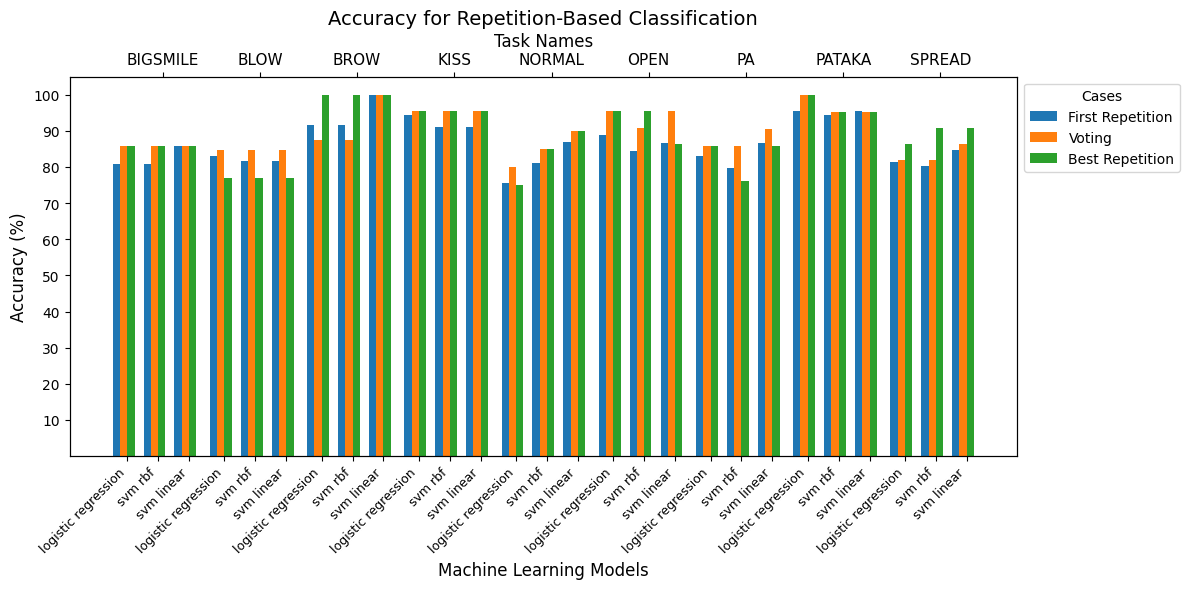

In [35]:
import matplotlib.pyplot as plt
import numpy as np

result = {'logistic regression': results_logistic_grid,'svm rbf':results_svm_rbf_grid, 'svm linear' :results_svm_linear_grid}
methods = list(result.keys())

# Gather all tasks from all methods (assuming they share the same tasks, or we take the union)
all_tasks = set()
for method in methods:
    all_tasks.update(result[method].keys())
# Sort tasks so they appear in a fixed order
tasks = sorted(all_tasks)  # e.g. ["BIGSMILE", "BLOW", "BROW", "KISS", "NORMAL", "OPEN", "PA", "PATAKA", "SPREAD"]

# We have 3 cases in each task dictionary
cases = ["First Repetition", "Voting", "Best Repetition"]

n_methods = len(methods)  # number of ML methods
n_tasks = len(tasks)      # number of tasks
n_cases = len(cases)      # number of cases

# Build a 3D array of shape (n_methods, n_tasks, n_cases) to store accuracies
data = np.zeros((n_methods, n_tasks, n_cases))
for i, method in enumerate(methods):
    for j, task in enumerate(tasks):
        for k, case in enumerate(cases):
            # Multiply by 100 to get percentage
            data[i, j, k] = result[method][task][case]["Accuracy"] * 100



fig, ax = plt.subplots(figsize=(12, 6))

# Parameters for layout:
bar_width = 0.8
gap = 1.0  # Increased gap between machine models (methods) for each task
# Calculate the width of one task group:
group_width = n_methods * (n_cases * bar_width + gap) + 0.5  # extra spacing between tasks
task_positions = np.arange(n_tasks) * group_width

case_colors = ["tab:blue", "tab:orange", "tab:green"]  # Colors for the 3 cases
labels_plotted = set()  # to avoid repeating legend labels

bottom_ticks = []
bottom_labels = []
top_ticks = []
top_labels = []

for j, task in enumerate(tasks):
    # Left boundary for this task group
    task_x_left = task_positions[j]

    # Label the top axis at the center of the group
    group_center = task_x_left + (n_methods * (n_cases * bar_width + gap)) / 2.0
    top_ticks.append(group_center)
    top_labels.append(task)

    # Now plot each method within this task
    offset = 0.0
    for i, method in enumerate(methods):
        # Label the bottom axis at the center of the current method's bars
        method_center = task_x_left + offset + (n_cases * bar_width) / 2.0
        bottom_ticks.append(method_center)
        bottom_labels.append(method)

        # Plot each case (side-by-side) for the current method
        for k, case in enumerate(cases):
            x_pos = task_x_left + offset
            height = data[i, j, k]

            # Draw the bar without annotation text
            ax.bar(
                x_pos,
                height,
                width=bar_width,
                color=case_colors[k],
                label=case if case not in labels_plotted else None
            )

            offset += bar_width  # move to the next case bar

        offset += gap  # add extra spacing between machine models

        # Mark that we've used these case labels (so they appear only once in the legend)
        labels_plotted.update(cases)

# Set up the y-axis: ticks from 10 to 100 in increments of 10
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_yticks(np.arange(10, 101, 10))

# Bottom axis: Methods
ax.set_xticks(bottom_ticks)
ax.set_xticklabels(bottom_labels, rotation=45, ha="right", fontsize=9)
ax.set_xlabel("Machine Learning Models", fontsize=12)

# Top axis: Tasks
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(top_ticks)
ax_top.set_xticklabels(top_labels, fontsize=11)
ax_top.set_xlabel("Task Names", fontsize=12)

# Legend for the 3 cases
ax.legend(title="Cases", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Accuracy for Repetition-Based Classification", fontsize=14)
plt.tight_layout()
plt.show()
